# Fine-tuned YAMNet: small aircraft detection

In [1]:
import pyaudio, librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Decide what type of messages are displayed by TensorFlow (ERROR, WARN, INFO, DEBUG, FATAL)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Disable eager execution for TF1 compatibility
tf.compat.v1.disable_eager_execution()

In [2]:
# TensorFlow memory allocation options:
# # OPTION 1: "smart" allocation
# config=tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess=tf.Session(config=config) 

# OPTION 2: maximum memory allocation per session (0-1 = 0-100%)
tf_ver = tf.__version__
if tf_ver[0] == "1":
    gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
elif tf_ver[0] == "2":
    gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.05)
    sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# OPTION 3: ???
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

# OPTION 4: ???
#Slim/embedded versions: (https://github.com/google-research/tf-slim)

print("tf version: ", tf.__version__)
print("tf.keras version: ", tf.keras.__version__)

tf version:  2.3.0
tf.keras version:  2.4.0


In [4]:
# Add/append required paths
import os, sys

path_root = '/home/ups/Proyectos/Vigia_sonido/' #path to root folder
path_model = path_root+"Models/yamnet_planes/"
# path_model = input("Enter the path of your repository: ") # ask user for path_model
assert os.path.exists(path_model)
sys.path.append(path_model)

path_yamnet_original = path_model+'yamnet_original/' #path to original yamnet files
assert os.path.exists(path_yamnet_original)
# sys.path.append(path_yamnet_original)

In [5]:
# Load functions
%run "yamnet_functions.py"

## YAMNet (original) predictions on a single audio

In [6]:
import yamnet_original.features as features
import yamnet_original.params as params
import yamnet_original.yamnet as yamnet

class_names = yamnet.class_names(path_yamnet_original+'yamnet_class_map.csv')

params.PATCH_HOP_SECONDS = 0.96 #low values: higher accuracy but higher computational cost
DESIRED_SR = params.SAMPLE_RATE # required by YAMNet

yamnet_vis = yamnet.yamnet_frames_model(params)
yamnet_vis.load_weights(path_model+'yamnet.h5')

In [8]:
# Understand impact of parameters on input image and visualise
# Load waveform
file_name = path_root+"Datasets/airplanes_v0/training_data/plane/track_04_0000_norm.wav"
waveform = read_wav(file_name, DESIRED_SR, use_rosa=True)
DESIRED_DURATION = 0.96 #[s]
waveform = waveform[0:round(DESIRED_DURATION*DESIRED_SR)] #the last data point does not need to be included in the STFT

print('Waveform size:', waveform.shape, 'and duration:', waveform.shape[0]/DESIRED_SR, '[s]\n')

# Calculate spectrogram
log_mel_spectrogram, magnitude_spectrogram, spectrogram = features.waveform_to_log_mel_spectrogram(waveform,params,print_on=1)

spectrogram = spectrogram.eval(session=sess)
magnitude_spectrogram = magnitude_spectrogram.eval(session=sess)
log_mel_spectrogram = log_mel_spectrogram.eval(session=sess)

print('Spectrogram (complex) size (x,y):',spectrogram.shape)
print('Spectrogram (magnitude) size (x,y):',magnitude_spectrogram.shape)
print('Log-scaled mel spectrogram size (x,y):',log_mel_spectrogram.shape,'\n')
 
# Calculate features (patches)
features_img = features.spectrogram_to_patches(log_mel_spectrogram, params, print_on=1)
features_img = features_img.eval(session=sess)

# Calculate scores
scores, _, _ = yamnet_vis.predict(np.reshape(waveform, [1, -1]), steps=1)

print('Features size (images,x,y):',features_img.shape)
print('Scores size (images,classes):',scores.shape)

Waveform size: (15360,) and duration: 0.96 [s]

SPECTROGRAM PARAMETERS:
stft_frame_length: 400
stft_frame_step: 160
fft_length: 512
fft_frequency_bins: 257 

Spectrogram (complex) size (x,y): (96, 257)
Spectrogram (magnitude) size (x,y): (96, 257)
Log-scaled mel spectrogram size (x,y): (96, 64) 

feature_frame_length: 96
feature_frame_step: 96 

Features size (images,x,y): (1, 96, 64)
Scores size (images,classes): (1, 521)


In [9]:
file_tmp = "/home/anakin/tmp_audio.wav"
play_audio(file_tmp,DESIRED_SR,waveform)

FileNotFoundError: [Errno 2] No such file or directory: '/home/anakin/tmp_audio.wav'

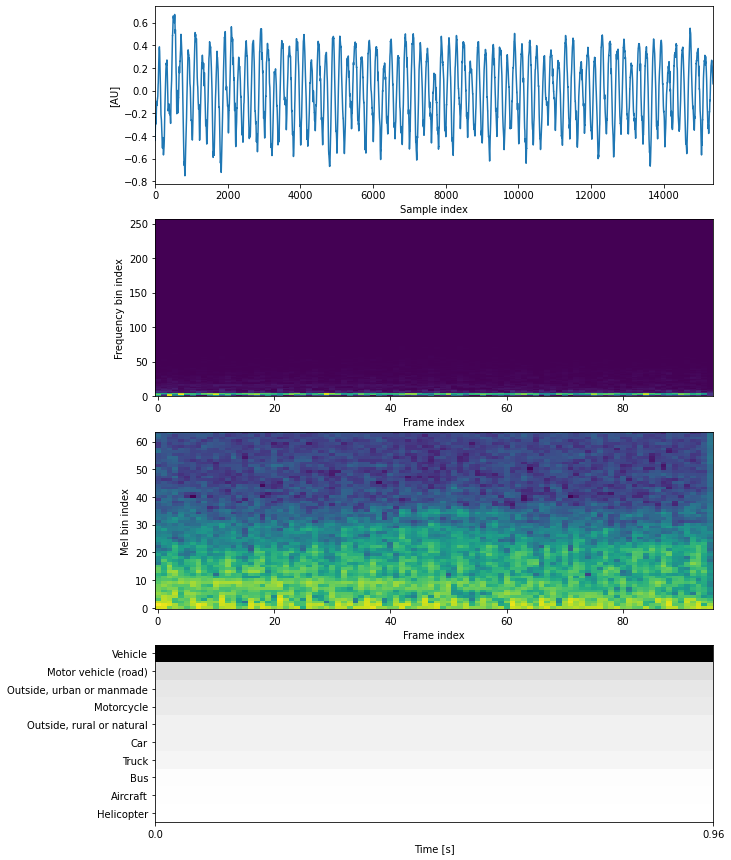

In [12]:
# Visualize the results
plt.figure(figsize=(10, 15))

# Plot the waveform
plt.subplot(4, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
plt.xlabel('Sample index')
plt.ylabel('[AU]')

# Plot the magnitude spectrogram
plt.subplot(4, 1, 2)
plt.imshow(magnitude_spectrogram.T, aspect='auto', interpolation='nearest', origin='lower')
plt.xlabel('Frame index')
plt.ylabel('Frequency bin index')

# Plot the log-scaled mel spectrogram
plt.subplot(4, 1, 3)
plt.imshow(log_mel_spectrogram.T, aspect='auto', interpolation='nearest', origin='lower')
plt.xlabel('Frame index')
plt.ylabel('Mel bin index')

# Plot and label the model output scores for the top-scoring classes for each 
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(4, 1, 4)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r', origin='lower')
# Compensate for the PATCH_HOP_SECONDS to align with log-scaled mel spectrogram
feature_frame_step = int(round(params.PATCH_HOP_SECONDS/params.STFT_HOP_SECONDS))
duration = log_mel_spectrogram.shape[0]/feature_frame_step
xlim_values = -0.5 + np.array([0, duration])
xtick_values = -0.5 + np.arange(0, scores.shape[0]+1)
xtick_labels = params.PATCH_HOP_SECONDS*np.arange(0, scores.shape[0]+1)
plt.xlim(xlim_values)
plt.xticks(xtick_values, xtick_labels)
plt.xlabel('Time [s]')
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
plt.ylim(-0.5 + np.array([top_N, 0]))

plt.show()

## Data augmentation
Random data augmentation is performed on the original waveforms. A feature vector is generated for every waveform which will later be used to train a fully-connected classifier. 


In [13]:
# Modified YAMNet model for feature extraction
import yamnet_original.params as params
import yamnet_modified as yamnet_modified

params.PATCH_HOP_SECONDS = 0.24 #low values: higher accuracy but higher computational cost
DESIRED_SR = params.SAMPLE_RATE # required by YAMNet

yamnet_features = yamnet_modified.yamnet_frames_model(params)
yamnet_features.load_weights(path_model+'yamnet.h5')

In [16]:
path_data_train = path_root+"Datasets/airplanes_v0/training_data/"
# path_data_train = input("Enter the path of your training dataset: ") # ask user for path_data_train
num_augmentations=1

samples, labels = data_augmentation(
    path_data_train, 
    yamnet_features,
    num_augmentations=num_augmentations,
    min_sample_seconds=1.5,
    max_sample_seconds=1000.0,
    use_rosa=True,
    DESIRED_SR=DESIRED_SR)

0%|          | 0/16 [00:00<?, ?it/s]Loading training data, number of augmentations = [1, 1]

Loading 0    -> 'not_plane'

Ignoring audio shorter than 1.5 seconds
 75%|███████▌  | 12/16 [00:02<00:00,  5.96it/s]
Ignoring audio shorter than 1.5 seconds
100%|██████████| 14/14 [00:02<00:00,  5.27it/s]'not_plane'          samples: 46%
'plane'              samples: 54%



In [17]:
# Randomise sample/label order
import random

idxs = list(range(len(labels)))
random.shuffle(idxs)

samples = [samples[i] for i in idxs]
labels = [labels[i] for i in idxs]

samples = np.array(samples)
labels = np.array(labels)

print(" Loaded samples: " , samples.shape, samples.dtype,  labels.shape)


Loaded samples:  (679, 1024) float32 (679,)


## Train a classifier using YAMNet's feature vector as input

In [18]:
# Classifier definition
from tensorflow.keras import Model, layers

def yamnet_classifier(input_size=1024,
    num_hidden=1024,
    num_classes=2):
    
    input_layer = layers.Input(shape=(input_size,)) #takes a vector of size (input_size,)
    dense_layer = layers.Dense(num_hidden, activation=None)(input_layer) #classifier layer with (num_hidden) neurons
    classifier_layer = layers.Dense(num_classes, activation='softmax')(dense_layer) #activation layer with (num_classes) neurons
    model = Model(inputs=input_layer, outputs=classifier_layer)
    return model

In [19]:
from tensorflow.keras.optimizers import SGD, Adam

features_img_length = 1024
num_hidden = 1024
num_classes = 2

yamnet_planes = yamnet_classifier(
    input_size=features_img_length, 
    num_hidden=num_hidden,
    num_classes=num_classes)

# Optimisation configuration
#opt = Adam(learning_rate=0.001)
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

yamnet_planes.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [20]:
# Train the classifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from time import time

# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
save_best = ModelCheckpoint('top_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
log_dir = "logs/{}".format(int(time()))
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = yamnet_planes.fit(samples, labels, epochs=50, validation_split=0.1, callbacks=[save_best])

Train on 611 samples, validate on 68 samples
Epoch 1/50
611/611 [==============================] - 0s 778us/sample - loss: 0.4850 - accuracy: 0.7840 - val_loss: 0.2935 - val_accuracy: 0.9412
Epoch 2/50
611/611 [==============================] - 0s 85us/sample - loss: 0.2012 - accuracy: 0.9607 - val_loss: 0.1551 - val_accuracy: 0.9853
Epoch 3/50
611/611 [==============================] - 0s 83us/sample - loss: 0.1258 - accuracy: 0.9804 - val_loss: 0.1083 - val_accuracy: 0.9853
Epoch 4/50
611/611 [==============================] - 0s 86us/sample - loss: 0.0961 - accuracy: 0.9885 - val_loss: 0.0832 - val_accuracy: 1.0000
Epoch 5/50
611/611 [==============================] - 0s 84us/sample - loss: 0.0785 - accuracy: 0.9951 - val_loss: 0.0679 - val_accuracy: 1.0000
Epoch 6/50
611/611 [==============================] - 0s 85us/sample - loss: 0.0673 - accuracy: 0.9951 - val_loss: 0.0563 - val_accuracy: 1.0000
Epoch 7/50
611/611 [==============================] - 0s 83us/sample - loss: 0.0585 

## Test on holdout sounds

In [21]:
# Load model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam

yamnet_planes = load_model(path_model+'top_model.hdf5')
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
yamnet_planes.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
yamnet_planes.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 1,051,650
Trainable params: 1,051,650
Non-trainable params: 0
_________________________________________________________________


In [22]:
## Specify class labels
class_labels = ["not plane", "plane"]

import yamnet_original.params as params
DESIRED_SR = params.SAMPLE_RATE # required by YAMNet


In [26]:
# Scores for a single holdout audio
file_name = path_root+"Datasets/airplanes_v0/holdout_data/plane/244330__vumseplutten1709__enginetuning10000_norm.wav"
waveform = read_wav(file_name, DESIRED_SR, use_rosa=1)

scores = run_models(waveform, yamnet_features, yamnet_planes)
scores = np.asarray(scores)[0]
winner = class_labels[scores.argmax()]

print(" Best score: {}  label: {}".format(scores.max(), winner))

Best score: 0.6634751558303833  label: plane


In [27]:
# Scores for testing folder
path_data_test = path_root+"Datasets/airplanes_v0/holdout_data/plane/"
arr = os.listdir(path_data_test)

for fname in arr:
    print(fname)
    fname = path_data_test+fname
    waveform = read_wav(fname, DESIRED_SR, use_rosa=1)

    # make file a bit longer by duplicating it 
    waveform = np.concatenate((waveform,waveform,waveform))
    scores = run_models(waveform, yamnet_features, yamnet_planes, strip_silence=False)
    winner_save = np.empty((0,2))
    if scores[0] != -1:
        winner = class_labels[scores.argmax()]
        print(" Best score: {}  label: {}".format(scores.max(), winner))
        # winner_save = np.append(winner_save,np.array([scores.max(),winner]),axis=0)

airplane+mustang_pip0000_norm.wav


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# result_array = np.empty((0, 2))
# result = np.array([1,"a"])
# result_array = np.append(result_array, [result], axis=0)
# result_array = np.append(result_array, [result], axis=0)

# result_array

In [ ]:
## Save the model for later
model.save("top_model_v3.h5", include_optimizer=False)